# Deep Q-Learning

Course Link: https://www.edreate.com/courses/reinforcement-learning/

Source: This notebook was taken from official PyTorch website (https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) and then modified.

In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

Reinforcement Learning (DQN) Tutorial
=====================================

**Author**: [Adam Paszke](https://github.com/apaszke)

:   [Mark Towers](https://github.com/pseudo-rnd-thoughts)

This tutorial shows how to use PyTorch to train a Deep Q Learning (DQN)
agent on the CartPole-v1 task from
[Gymnasium](https://gymnasium.farama.org).

You might find it helpful to read the original [Deep Q Learning
(DQN)](https://arxiv.org/abs/1312.5602) paper

**Task**

The agent has to decide between two actions - moving the cart left or
right - so that the pole attached to it stays upright. You can find more
information about the environment and other more challenging
environments at [Gymnasium\'s
website](https://gymnasium.farama.org/environments/classic_control/cart_pole/).

As the agent observes the current state of the environment and chooses
an action, the environment *transitions* to a new state, and also
returns a reward that indicates the consequences of the action. In this
task, rewards are +1 for every incremental timestep and the environment
terminates if the pole falls over too far or the cart moves more than
2.4 units away from center. This means better performing scenarios will
run for longer duration, accumulating larger return.

The CartPole task is designed so that the inputs to the agent are 4 real
values representing the environment state (position, velocity, etc.). We
take these 4 inputs without any scaling and pass them through a small
fully-connected network with 2 outputs, one for each action. The network
is trained to predict the expected value for each action, given the
input state. The action with the highest expected value is then chosen.

**Packages**

First, let\'s import needed packages. Firstly, we need
[gymnasium](https://gymnasium.farama.org/) for the environment,
installed by using [pip]{.title-ref}. This is a fork of the original
OpenAI Gym project and maintained by the same team since Gym v0.19. If
you are running this in Google Colab, run:

``` {.sourceCode .bash}
%%bash
pip3 install gymnasium[classic_control]
```

We\'ll also use the following from PyTorch:

-   neural networks (`torch.nn`)
-   optimization (`torch.optim`)
-   automatic differentiation (`torch.autograd`)


In [2]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
from typing import Deque, List
from datetime import datetime
import numpy as np

from models import PolicyNetwork

from torchsummary import summary

In [3]:
env = gym.make("LunarLander-v3", continuous=False, render_mode="rgb_array")

# Get number of actions from gym action space
n_actions = int(env.action_space.n)
print(f"Number of possible actions: {n_actions}")
print("""Actions:
0: do nothing
1: fire left orientation engine
2: fire main engine
3: fire right orientation engine
""")

# Get the number of state observations
state, info = env.reset()
n_observations = len(state)
print(f"Number of state observations: {n_observations}")

print("""State (Observation Space):
x, y
vel_x, vel_y
angle, angle_vel
left_leg_touching, right_leg_touching
      """)
print("Current state: ", state)

print("""Units of the state are as follows:
      ‘x’: (units), ‘y’: (units), 
      ‘vx’: (units/second), ‘vy’: (units/second), 
      ‘angle’: (radians), ‘angular velocity’: (radians/second)
      """)

Number of possible actions: 4
Actions:
0: do nothing
1: fire left orientation engine
2: fire main engine
3: fire right orientation engine

Number of state observations: 8
State (Observation Space):
x, y
vel_x, vel_y
angle, angle_vel
left_leg_touching, right_leg_touching
      
Current state:  [ 0.00205441  1.4159197   0.20806813  0.22220829 -0.0023737  -0.04713054
  0.          0.        ]
Units of the state are as follows:
      ‘x’: (units), ‘y’: (units), 
      ‘vx’: (units/second), ‘vy’: (units/second), 
      ‘angle’: (radians), ‘angular velocity’: (radians/second)
      


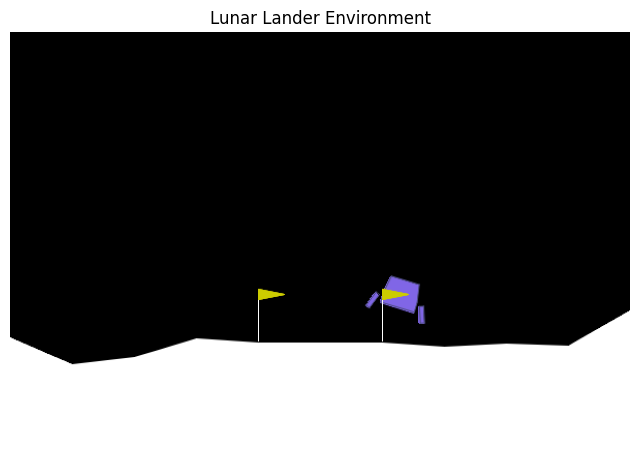

In [4]:
# Reset the environment to get the initial state
state, info = env.reset()

for i in range(50):
    env.step(action=0)
# Render the environment to get an RGB image
frame = env.render()

# Plot the image
plt.figure(figsize=(8, 6))
plt.imshow(frame)
plt.axis("off")
plt.title("Lunar Lander Environment")
plt.show()

In [5]:
# set up matplotlib
is_ipython = "inline" in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [6]:
# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Using device: ", device)

# device = torch.device("cpu")

Using device:  cuda


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class PolicyNetwork(nn.Module):
    """
    Neural network for policy-based reinforcement learning.

    Architecture:
    - Input layer: Accepts `num_inputs` features representing the state.
    - Hidden layers: Two fully connected layers with 256 units each and ReLU activation for non-linearity.
    - Output layer: Produces `num_outputs`, representing action space size or logits.

    Args:
        num_inputs (int): Number of input features (state size).
        num_outputs (int): Number of output features (action size).

    Methods:
        forward(x): Propagates the input through the network.
    """

    def __init__(self, num_inputs: int, num_outputs: int) -> None:
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(num_inputs, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, num_outputs)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, num_inputs).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, num_outputs).
        """
        return self.net(x)

Replay Memory
=============

We\'ll be using experience replay memory for training our PolicyNetwork. It stores
the transitions that the agent observes, allowing us to reuse this data
later. By sampling from it randomly, the transitions that build up a
batch are decorrelated. It has been shown that this greatly stabilizes
and improves the PolicyNetwork training procedure.

For this, we\'re going to need two classes:

-   `Transition` - a named tuple representing a single transition in our
    environment. It essentially maps (state, action) pairs to their
    (next\_state, reward) result, with the state being the screen
    difference image as described later on.
-   `ReplayMemory` - a cyclic buffer of bounded size that holds the
    transitions observed recently. It also implements a `.sample()`
    method for selecting a random batch of transitions for training.


In [8]:
# Define the type of the Transition tuple
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward", "done"))


# ReplayMemory class with strong type hints
class ReplayMemory:
    def __init__(self, capacity: int):
        # The deque stores Transition objects
        self.memory: Deque[Transition] = deque([], maxlen=capacity)

    def push(self, state: float, action: int, next_state: float, reward: float, done: bool) -> None:
        """Save a transition"""
        self.memory.append(Transition(state, action, next_state, reward, int(done)))

    def sample(self, batch_size: int) -> List[Transition]:
        """Sample a batch of transitions"""
        return random.sample(self.memory, batch_size)

    def __len__(self) -> int:
        """Return the current size of the memory"""
        return len(self.memory)

In [9]:
# net = PolicyNetwork(n_observations, n_actions)

# summary(net, input_size=(1, n_observations, n_actions))

Now, let\'s define our model. But first, let\'s quickly recap what a DQN
is.

DQN algorithm
=============

Our environment is deterministic, so all equations presented here are
also formulated deterministically for the sake of simplicity. In the
reinforcement learning literature, they would also contain expectations
over stochastic transitions in the environment.

Our aim will be to train a policy that tries to maximize the discounted,
cumulative reward
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, where $R_{t_0}$
is also known as the *return*. The discount, $\gamma$, should be a
constant between $0$ and $1$ that ensures the sum converges. A lower
$\gamma$ makes rewards from the uncertain far future less important for
our agent than the ones in the near future that it can be fairly
confident about. It also encourages agents to collect reward closer in
time than equivalent rewards that are temporally far away in the future.

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell us
what our return would be, if we were to take an action in a given state,
then we could easily construct a policy that maximizes our rewards:

$\pi^*(s) = \arg\!\max_a \ Q^*(s, a)$

However, we don\'t know everything about the world, so we don\'t have
access to $Q^*$. But, since neural networks are universal function
approximators, we can simply create one and train it to resemble $Q^*$.

For our training update rule, we\'ll use a fact that every $Q$ function
for some policy obeys the Bellman equation:

$Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))$

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

$\delta = Q(s, a) - (r + \gamma \max_a' Q(s', a))$

To minimize this error, we will use the [Huber
loss](https://en.wikipedia.org/wiki/Huber_loss). The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate this
over a batch of transitions, $B$, sampled from the replay memory:

$\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)$

$\begin{aligned}
\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
  \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
  |\delta| - \frac{1}{2} & \text{otherwise.}
\end{cases}
\end{aligned}$

Q-network
---------

Our model will be a feed forward neural network that takes in the
difference between the current and previous screen patches. It has two
outputs, representing $Q(s, \mathrm{left})$ and $Q(s, \mathrm{right})$
(where $s$ is the input to the network). In effect, the network is
trying to predict the *expected return* of taking each action given the
current input.


Let's break this down step by step:
1. **Q-network (Deep Q-Network)** In Deep Q-Learning, a **Q-network**  is a type of neural network that approximates the **Q-value function** . The Q-value function, $Q(s, a)$, estimates the "quality" (or expected future rewards) of taking a particular action $a$ when the system is in a particular state $s$.
#### In simple terms: 
   - **State (s)** : Represents the current situation or observation of the environment. In your case, the "screen patches" (from the text) are the state.
    
   - **Action (a)** : Represents a decision or movement the agent can make, such as moving **left**  or **right**  in a game.
    
   - **Q(s, a)** : Represents the **expected return**  (future rewards) if the agent takes action $a$ in state $s$.
- 
The Q-network learns to approximate the function $Q(s, a)$, which tells the agent how "good" each possible action is when it's in state $s$.

2. **Inputs to the Q-network** In your case, the model is a **feed-forward neural network**  (a basic type of neural network) that takes as input the **difference between the current and previous screen patches** . 
- **Current and Previous Screen Patches** :
  - These could be image patches or some form of observation data representing the environment.

  - The difference between the two patches could be computed to highlight changes in the environment, which can help the agent focus on what has changed.

  - This input helps the agent understand the dynamics of the environment, such as which way objects are moving or if a threat has appeared/disappeared.
3. **Two Outputs: $Q(s, \mathrm{left})$ and $Q(s, \mathrm{right})$** 
   
The network has **two outputs** . These outputs correspond to the **Q-values**  for two possible actions: moving **left**  and moving **right** . 
   - $Q(s, \mathrm{left})$: This output represents the estimated **expected return**  or **expected future reward**  if the agent takes the **left**  action in the current state $s$.
    
   - $Q(s, \mathrm{right})$: Similarly, this output represents the expected return if the agent takes the **right**  action.
  
4. **What the Network is Doing** The goal of the Q-network is to predict the **expected return**  for each action given the current input (the state $s$). 
   - **Expected Return** : This is the sum of future rewards the agent expects to receive after taking a particular action, given the current state.
    
   - The agent will select the action (either **left**  or **right** ) that has the **highest Q-value**  because this is the action expected to yield the most future reward.

5. **Why Two Outputs?** The two outputs $Q(s, \mathrm{left})$ and $Q(s, \mathrm{right})$ allow the agent to compare the expected returns of different actions directly. When it's time to act, the agent will pick the action with the **higher Q-value** : 
   
   - If $Q(s, \mathrm{left}) > Q(s, \mathrm{right})$, the agent will move **left** .
    
   - If $Q(s, \mathrm{right}) > Q(s, \mathrm{left})$, the agent will move **right** .

6. **Training the Q-network** 
   The Q-network is trained by interacting with the environment. The agent takes actions, receives rewards, and uses the observed outcomes to adjust the Q-values. This process is done through **Q-learning**  with a loss function based on the **Bellman equation** , which updates the Q-values to better predict the expected returns over time.
   
### Summary: 
 
   - **Q-network** : A neural network that approximates the Q-value function $Q(s, a)$, where $s$ is the state and $a$ is the action.
    
   - **Input** : The difference between the current and previous observations (e.g., screen patches).
    
   - **Output** : Two values, representing $Q(s, \mathrm{left})$ and $Q(s, \mathrm{right})$, which estimate the expected returns of moving left and right.
    
   - **Purpose** : The network helps the agent decide which action to take by predicting which action will lead to the most reward over time.

This structure allows the agent to **learn**  which actions are best to take in various situations to maximize cumulative rewards.


In [10]:
PolicyNetwork

__main__.PolicyNetwork

Training
========

Hyperparameters and utilities
-----------------------------

This cell instantiates our model and its optimizer, and defines some
utilities:

-   `select_action` - will select an action according to an epsilon
    greedy policy. Simply put, we\'ll sometimes use our model for
    choosing the action, and sometimes we\'ll just sample one uniformly.
    The probability of choosing a random action will start at
    `EPS_START` and will decay exponentially towards `EPS_END`.
    `EPS_DECAY` controls the rate of the decay.


In [11]:
def select_action(state):
    global steps_done  # Use a global variable to track the number of steps done so far in training.

    sample = (
        random.random()
    )  # Generate a random number between 0 and 1 to decide whether to explore or exploit. This is uniform distribution

    # Calculate the current epsilon threshold (ε) for epsilon-greedy action selection.
    # EPS_START is the initial exploration rate, EPS_END is the final exploration rate,
    # and EPS_DECAY controls how quickly ε decays over time.
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1.0 * steps_done / EPS_DECAY)

    steps_done += 1  # Increment the step counter.

    # If the random sample is greater than the epsilon threshold, exploit (choose the best action).
    # Be greedy
    if sample > eps_threshold:
        with torch.no_grad():  # Turn off gradient calculation, as we only want to select an action, not back-propagate.
            # policy_net(state) returns the Q-values for all actions given the current state.
            # .max(1) returns the maximum Q-value along the columns (actions) for each row (state).
            # The second value returned by max() is the index of the action with the maximum Q-value.
            # indices.view(1, 1) reshapes the result to match the expected output format.
            return policy_net(state).max(1).indices.view(1, 1)

    # If the random sample is less than the epsilon threshold, explore (choose a random action).
    # Be not greedy, take a random action even if it doesn't benefit you
    else:
        # env.action_space.sample() selects a random action from the action space of the environment.
        # Convert it to a tensor with the appropriate device and data type (long integer).
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

    print("Current EPS Threshold: ", eps_threshold)

In [12]:
EPS_START = 0.9  # EPS_START is the starting value of epsilon (high exploration)
EPS_END = 0.05  # the final value of epsilon (minimal exploration)
EPS_DECAY = 1000  # Decay rate, controls the rate of exponential decay of epsilon, higher means a slower decay

#### Epsilon decay visualized

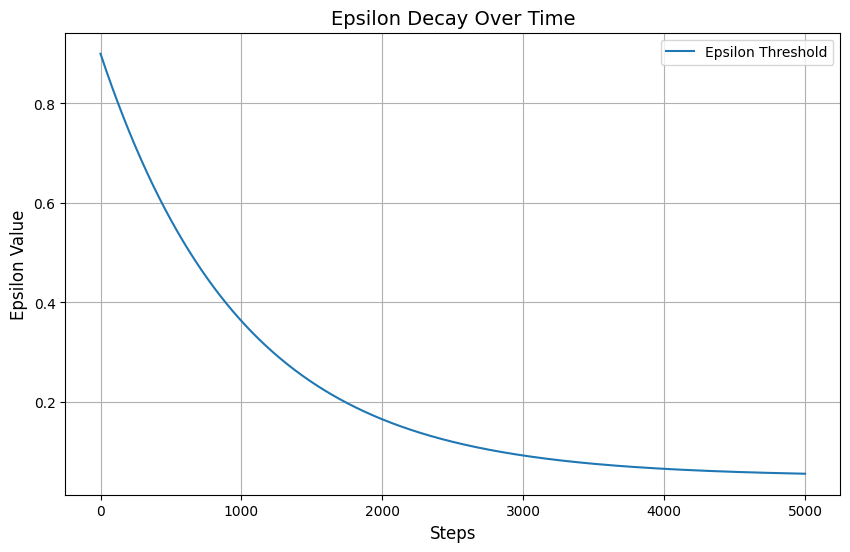

In [13]:
## This code cell is just for visualization

# Number of steps to simulate
total_steps = 5000
# Create a list to store the epsilon values over time
eps_values = []

# Calculate epsilon for each step
for steps_done in range(total_steps):
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1.0 * steps_done / EPS_DECAY)
    eps_values.append(eps_threshold)

# Plot epsilon over time
plt.figure(figsize=(10, 6))
plt.plot(eps_values, label="Epsilon Threshold")
plt.title("Epsilon Decay Over Time", fontsize=14)
plt.xlabel("Steps", fontsize=12)
plt.ylabel("Epsilon Value", fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

## This code cell is just for visualization

In [14]:
BATCH_SIZE = 128  # BATCH_SIZE is the number of transitions sampled from the replay buffer
GAMMA = 0.99  # GAMMA is the discount factor as mentioned in the previous section

TAU = 0.005  # TAU is the update rate of the target network
LR = 1e-4  # LR is the learning rate of the ``AdamW`` optimizer

**`plot_durations`**

A helper for plotting the duration of episodes,
along with an average over the last 100 episodes (the measure used
in the official evaluations). The plot will be underneath the cell
containing the main training loop, and will update after every
episode.

In [15]:
def plot_durations(episode_durations, rewards,show_result=False, save_path=None):
    plt.figure(figsize=(10, 5))
    
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    
    if show_result:
        plt.title("Result")
    else:
        plt.clf()
        plt.title("Training...")

    plt.xlabel("Episode")
    plt.ylabel("Duration")
    
    plt.plot(durations_t.numpy())
    plt.plot(np.array(rewards))

    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path + "_dqn_cartpolev1_policy_net_result_plot", dpi=300)
        print(f"Figure saved to {save_path}")

    if 'get_ipython' in globals():
        if not show_result:
            display.clear_output(wait=True)
            display.display(plt.gcf())
        else:
            display.display(plt.gcf())
    else:
        plt.show()

    plt.close()

In [16]:
# Initialize NNs

# Initialize the policy network (the neural network that will be trained).
# The input size is the number of observations (state dimensions), and the output size is the number of actions.
policy_net = PolicyNetwork(n_observations, n_actions).to(device)

# Initialize the target network (a separate copy of the policy network).
# This network will not be trained directly, but its weights will be periodically updated to the policy network's weights.
target_net = PolicyNetwork(n_observations, n_actions).to(device)

# Copy the weights and biases from the policy network to the target network.
# This ensures that the target network starts with the same parameters as the policy network.
target_net.load_state_dict(policy_net.state_dict())

# Huber loss
criterion = nn.SmoothL1Loss()

In [17]:
# Optimizer for training
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

number_of_replay_memory_samples = 10000
memory = ReplayMemory(number_of_replay_memory_samples)

print("We will keep a replay memory of: ", number_of_replay_memory_samples)

We will keep a replay memory of:  10000


In [18]:
# Training length based on the hardware available
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 50

Training loop
=============

Finally, the code for training our model.

Here, you can find an `optimize_model` function that performs a single
step of the optimization. It first samples a batch, concatenates all the
tensors into a single one, computes $Q(s_t, a_t)$ and
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our loss. By
definition we set $V(s) = 0$ if $s$ is a terminal state. We also use a
target network to compute $V(s_{t+1})$ for added stability. The target
network is updated at every step with a [soft
update](https://arxiv.org/pdf/1509.02971.pdf) controlled by the
hyperparameter `TAU`, which was previously defined.


In [19]:
def optimize_model():
    # Check if there are enough samples in memory to form a batch
    if len(memory) < BATCH_SIZE:
        return  # If not enough samples, exit the function early

    # 1. Sample a batch of transitions from memory
    transitions = memory.sample(BATCH_SIZE)

    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    # Transpose the batch to create a batch of each component (state, action, etc.)
    # This converts a list of Transition objects into a Transition object
    # containing tensors for states, actions, rewards, and next states.
    # Example: If transitions contains three Transition objects, each with 
    # state, action, reward, next_state, the zip(*transitions) will group 
    # them into separate lists for each property.
    # so we can do:
    # batch.state
    # batch.action
    # batch.next_state
    # batch.reward
    # 2. Transpose the batch to group data by type (state, action, reward, next_state).
    batch = Transition(*zip(*transitions))
    
    # 3. Create a mask for non-final states and concatenate non-final next states.
    # Create a mask to identify non-final states
    # A non-final state is one for which there is a next state available;
    # we use a boolean mask to easily filter states that are not final.
    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool
    )
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    # 4. Prepare data batches for training (state, action, reward).
    # Concatenate the batch components into single tensors
    # This prepares the batches for input into the neural network
    state_batch = torch.cat(batch.state, dim=0)
    action_batch = torch.cat(batch.action, dim=0)
    reward_batch = torch.cat(batch.reward, dim=0)

    # 5. Compute Q-values for current state-action pairs using the policy network.
    # Q-values represent the expected cumulative reward for taking a specific action
    # in a given state and then following the optimal policy thereafter.
    # 
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    # (5 in 2 separate steps)
    ## Step 1: Compute Q-values for all actions in the given states
    # all_q_values = policy_net(state_batch)
    # Step 2: Select Q-values for the actions that were actually taken
    # state_action_values = all_q_values.gather(1, action_batch)
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # 6. Compute V-values for next states using the target network. 
    # V-values represent the expected cumulative reward from being in a particular
    # state and following the optimal policy from that point on. In this context,
    # it's calculated as the maximum Q-value for the next state.
    #
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # 7. Calculate expected Q-values using the Bellman equation. This step combines the 
    # immediate reward with the discounted future value (V-value) to get the target Q-value.
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # 8. Compute the loss between current and expected Q-values. 
    # Compute Huber loss
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # 9. Perform gradient descent
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [30]:
def plot_metrics(episode_durations, rewards, show_result=False, save_path=None):
    # Create a horizontal figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=100)
    fig.suptitle("Training Metrics" if not show_result else "Results", fontsize=16)

    # Plot Episode Durations
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    axes[0].set_title("Episode Durations")
    axes[0].set_xlabel("Episode")
    axes[0].set_ylabel("Duration")
    axes[0].plot(durations_t.numpy(), label="Duration")
    
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        axes[0].plot(means.numpy(), label="100-Episode Avg", linestyle="--")
    
    axes[0].legend()

    # Plot Rewards
    rewards_t = torch.tensor(rewards, dtype=torch.float)
    axes[1].set_title("Rewards")
    axes[1].set_xlabel("Episode")
    axes[1].set_ylabel("Reward")
    axes[1].plot(rewards_t.numpy(), label="Reward")
    
    if len(rewards_t) >= 100:
        reward_means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        reward_means = torch.cat((torch.zeros(99), reward_means))
        axes[1].plot(reward_means.numpy(), label="100-Episode Avg", linestyle="--")
    
    axes[1].legend()

    # Adjust layout and save/show
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Add space for the suptitle
    if save_path:
        plt.savefig(save_path + ".png" , dpi=300)
        print(f"Metrics figure saved to {save_path}")

    if 'get_ipython' in globals():
        if not show_result:
            display.clear_output(wait=True)
            display.display(fig)
        else:
            display.display(fig)
    else:
        plt.show()

    plt.close(fig)

In [21]:
# Get the current timestamp in a readable format (Year-Month-Day_Hour-Minute-Second)
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

Below, you can find the main training loop. At the beginning we reset
the environment and obtain the initial `state` Tensor. Then, we sample
an action, execute it, observe the next state and the reward (always 1),
and optimize our model once. When the episode ends (our model fails), we
restart the loop.

Below, [num\_episodes]{.title-ref} is set to 600 if a GPU is available,
otherwise 50 episodes are scheduled so training does not take too long.
However, 50 episodes is insufficient for to observe good performance on
CartPole. You should see the model constantly achieve 500 steps within
600 training episodes. Training RL agents can be a noisy process, so
restarting training can produce better results if convergence is not
observed.


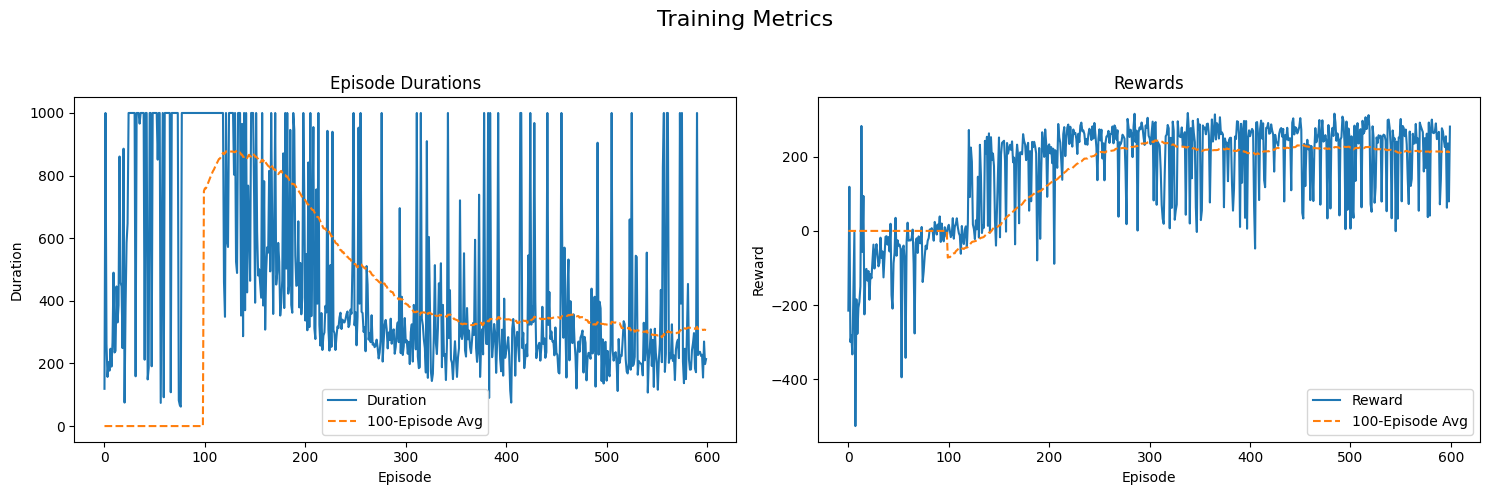

Complete


In [ ]:
steps_done = 0  # Step counter to track how many actions have been taken.
episode_durations = []  # List to store the duration (i.e., time steps) for each episode.
rewards_over_episode = []
best_cumulative_reward_for_episode = -500.0

for i_episode in range(num_episodes):

    # Step 1: Reset the environment at the start of each episode and get the initial state.
    state, info = env.reset()  # Reset the environment and get the initial state.
    
    # Step 2: Convert the state into a tensor and add a batch dimension (unsqueeze(0)).
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    # Step 3: Start an episode loop (for each time step in the current episode).
    cumulative_reward_for_episode = 0.0

    for t in count():
        # Step 4: Select an action based on the current state using the policy network (with exploration).
        action = select_action(state)
        
        # Step 5: Take the action in the environment and receive the next observation, reward, and done flags.
        observation, reward, terminated, truncated, _ = env.step(action.item())

        cumulative_reward_for_episode += reward
        
        # Step 6: Convert the reward into a tensor.
        reward = torch.tensor([reward], device=device)

        # Step 7: Check if the episode is done (either terminated or truncated).
        done = terminated or truncated

        # Step 8: If the episode has terminated, set `next_state` to None (i.e., no next state).
        if terminated:
            next_state = None
        else:
            # Step 9: Otherwise, convert the next observation into a tensor with a batch dimension.
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Step 10: Store the transition (state, action, next state, reward) in memory for replay.
        memory.push(state, action, next_state, reward, done)

        # Step 11: Move to the next state (update the current state to the new state).
        state = next_state

        # Step 12: Perform one step of optimization on the policy network (train the model).
        optimize_model()

        # Step 13: Soft update the target network’s weights (perform a gradual update).
        # θ′ ← τ θ + (1 − τ) θ′, where θ′ is the target network and θ is the policy network.
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)

        # Step 14: If the episode is done, record the duration of the episode.
        if done:
            episode_durations.append(t + 1)
            rewards_over_episode.append(cumulative_reward_for_episode)

            if cumulative_reward_for_episode  > best_cumulative_reward_for_episode:
                best_cumulative_reward_for_episode = cumulative_reward_for_episode

                filename = f"output/dqn_policy_network_lunar_lander_v3_{timestamp}.pth"

                # Save the policy network with the dynamically generated filename
                torch.save(policy_net.state_dict(), filename)
                print(f"Cumulative reward: {cumulative_reward_for_episode}, Model saved as: {filename}")

            # Step 15: Update the plot showing the episode durations.
            plot_metrics(episode_durations=episode_durations, rewards = rewards_over_episode, save_path=filename)
            break  # Exit the time step loop and start the next episode.

# After all episodes are complete, print a message and show the final results.
print("Complete")

Here is the diagram that illustrates the overall resulting data flow.

![](https://pytorch.org/tutorials/_static/img/reinforcement_learning_diagram.jpg)

Actions are chosen either randomly or based on a policy, getting the
next step sample from the gym environment. We record the results in the
replay memory and also run optimization step on every iteration.
Optimization picks a random batch from the replay memory to do training
of the new policy. The \"older\" target\_net is also used in
optimization to compute the expected Q values. A soft update of its
weights are performed at every step.


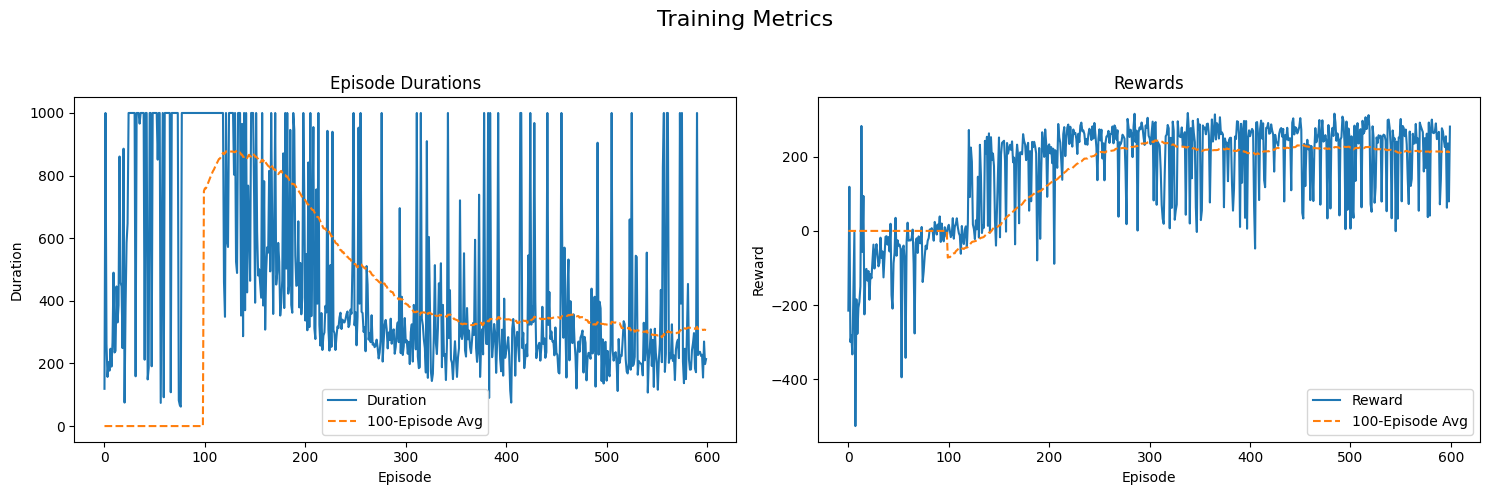

In [31]:
plt.ion()
plot_metrics(episode_durations=episode_durations, rewards = rewards_over_episode, save_path=filename)